In [1]:
import pandas as pd
import os
import numpy as np
from abag_affinity.utils.config import read_config, get_data_paths

In [2]:
config = read_config("../abag_affinity/config.yaml")
summary_path, pdb_path = get_data_paths(config, "Dataset_v1")
pdb_path = pdb_path[0]
data_df = pd.read_csv(summary_path)

In [3]:
data_df.head()

,index,pdb,abdb_file,antigen_type,antibody_chains,antigen_chains,affinity_method,temperature,calculated_temp,affinity,delta_g,test,validation
0,0,2r56,2R56_1.pdb,protein,"['I', 'M', 'H', 'L']","['B', 'A']",SPR,NaN,25.0,1.300000e-09,-12.120000,False,1
1,263,4dke,4DKE_1.pdb,protein,"['I', 'M', 'H', 'L']","['B', 'A']",SPR,NaN,25.0,1.200000e-10,-13.534418,False,3
2,262,5zia,5ZIA_1.pdb,peptide,"['G', 'L', 'O', 'P', 'A', 'B', 'D', 'E', 'H', ...","['R', 'Q', 'C', 'F', 'J', 'N']",Unknown,NaN,25.0,3.000000e-07,-8.898799,False,3
3,261,1uwx,1UWX_1.pdb,peptide,"['H', 'L', 'M', 'K']","['P', 'Q']",SPR,NaN,25.0,1.600000e-06,-7.900000,False,3
4,260,4hwb,4HWB_1.pdb,protein,"['H', 'L']",['A'],Unknown,NaN,25.0,5.700000e-10,-12.611243,False,2


In [4]:
def calc_residue_dist(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    for row, residue_one in enumerate(chain_one):
        if "CA" not in residue_one:
            break
        for col, residue_two in enumerate(chain_two):
            if "CA" not in residue_two:
                break
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    
    return answer[:row, :col]

In [5]:
len(data_df)

413

## Quick Analysis of SARS Cov Spike Protein

In [6]:
from abag_affinity.utils.pdb_reader import read_file

pdb_path = "/home/fabian/Desktop/Uni/Masterthesis/ag_binding_affinity/resources/AbDb/NR_LH_Protein_Martin/"

row = data_df[data_df["pdb"] == "2DD8".lower()].iloc[0]  # sars-cov spike protein
path = os.path.join(pdb_path, row["abdb_file"])

#path = "../../data/test/1mhh.pdb"
print("Getting Strcuture for {}".format(row["pdb"]))
print("Binding Affinity >>>", row["affinity"])

structure, header= read_file(row["pdb"], path)
model = structure[0]

Getting Strcuture for 2dd8
Binding Affinity >>> 2e-08


In [7]:
chains = list(model.get_chains())[:3]
chains

[<Chain id=L>, <Chain id=H>, <Chain id=S>]

In [8]:
dist_matrix = calc_dist_matrix(model["H"], model["H"])
contact_map = dist_matrix < 10.0

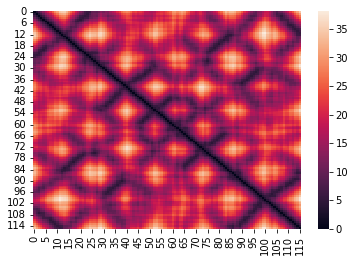

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(dist_matrix)

plt.show()

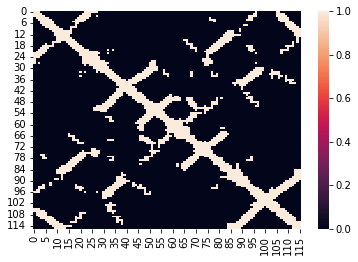

In [10]:
sns.heatmap(contact_map)
plt.show()

Check 3D Structure on https://www.rcsb.org/3d-sequence/2DD8?assemblyId=1

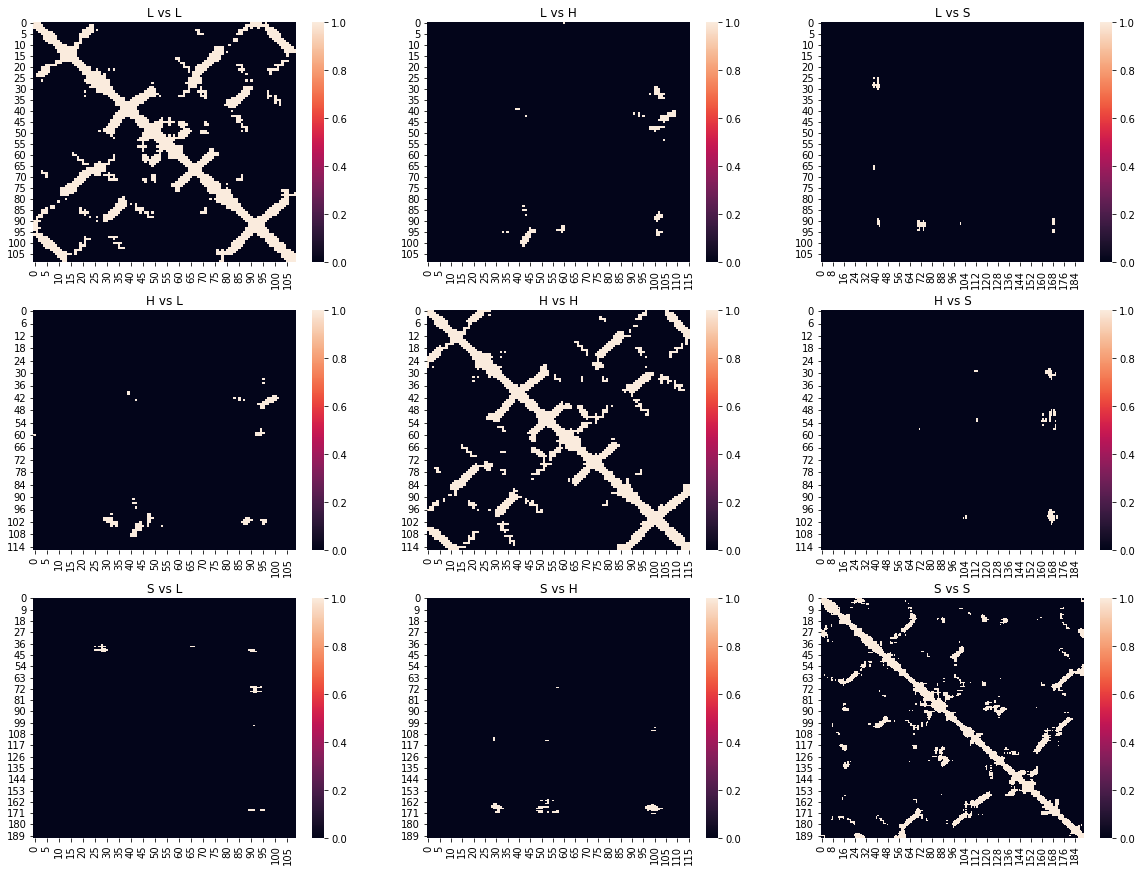

In [11]:
fig, ax = plt.subplots(len(chains), len(chains), figsize=(20,15))
for i, chain in enumerate(chains):
    for j, chain_1 in enumerate(chains):
        dist_matrix = calc_dist_matrix(chain, chain_1)
        contact_map = dist_matrix < 10.0
        sns.heatmap(contact_map, ax=ax[i, j])
        ax[i, j].set_title(chain.id + " vs " + chain_1.id)
        
plt.show()

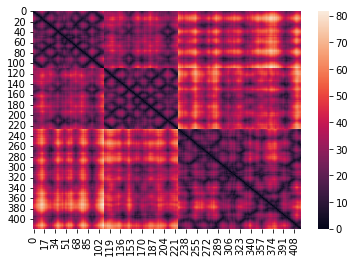

In [12]:
import string
from abag_affinity.utils.pdb_processing import get_distances_and_info

alphabet_letters = set(string.ascii_lowercase)

chain_id2protein = {"l": "antibody", "h": "antibody"} # heavy and light chains of antibodies are often called l and h
for chain_id in row["antibody_chains"]:
    chain_id2protein[chain_id.lower()] = "antibody"

for chain_id in row["antigen_chains"]:
    chain_id2protein[chain_id.lower()] = "antigen"
for letter in alphabet_letters - set(chain_id2protein.keys()):
    chain_id2protein[letter] = "antigen"

distances, residue_infos, residue_atom_coordinates, structure_info, closest_residue_indices = get_distances_and_info(structure, header, chain_id2protein)

chain_lengths = []
for chain in structure.get_chains():
    residue_list = list(chain.get_residues())
    chain_name = chain.id
    chain_lengths.append((len(residue_list), chain_name))

    
sns.heatmap(distances)

plt.show()

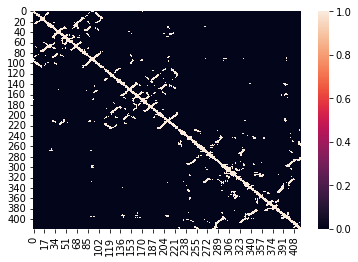

In [13]:
contact_map = distances < 10.0
sns.heatmap(contact_map)

plt.show()

### Use all atoms to calculate distances and not only C-alpha atom

/home/fabian/miniconda3/envs/ag_binding_affinity/lib/python3.7/site-packages/scipy/spatial/kdtree.py:51: RuntimeWarning: invalid value encountered in subtract
  return np.sum(np.abs(y-x)**p, axis=-1)


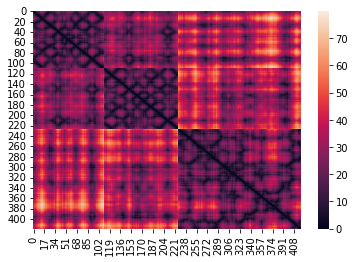

In [14]:
distances, residue_infos, residue_atom_coordinates, structure_info, closest_residue_indices = get_distances_and_info(structure, header, chain_id2protein, ca_distance=False)
    
sns.heatmap(distances)

plt.show()

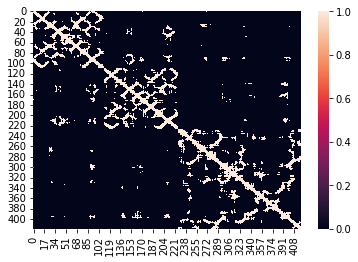

In [18]:
contact_map = distances < 10.0
sns.heatmap(contact_map)

plt.show()

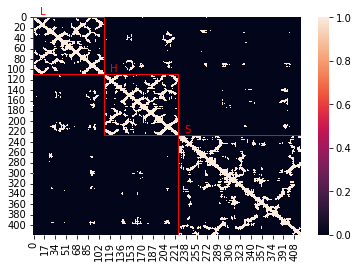

In [19]:
from matplotlib.patches import Rectangle

ax = sns.heatmap(contact_map)

total_length = 0
for length, chain_name in chain_lengths:
    plt.text(total_length + 10, total_length - 5, chain_name, color="r")
    rect = Rectangle((total_length, total_length), length, length, linewidth=1, edgecolor='r', facecolor='none')
    total_length += length
    ax.add_patch(rect)

plt.show()
